<a href="https://colab.research.google.com/github/noweahc/energy/blob/main/DBSCAN_%26_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 전력 사용량 비슷한 건물끼리 군집화

### BASELINE

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import os

In [19]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [21]:
train = pd.read_csv('/content/drive/MyDrive/23energy/23data/train.csv',encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/23energy/23data/test.csv',encoding = 'utf-8')
building = pd.read_csv('/content/drive/MyDrive/23energy/23data/building_info.csv',encoding = 'utf-8')

In [22]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

In [23]:
test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [24]:
building = building.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [25]:
train = pd.merge(train, building, on='building_number', how='left')
test = pd.merge(test, building, on='building_number', how='left')

In [26]:
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)

    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)

    return train

In [27]:
train = make_time(train)
test = make_time(test)

In [28]:
# 문자열을 실수형으로 변환하고 "-"을 0으로 대체합니다.
train["solar_power_capacity"] = train["solar_power_capacity"].apply(lambda x: float(x) if x != "-" else 0)
train["ess_capacity"] = train["ess_capacity"].apply(lambda x: float(x) if x != "-" else 0)
train["pcs_capacity"] = train["pcs_capacity"].apply(lambda x: float(x) if x != "-" else 0)

# 문자열을 실수형으로 변환하고 "-"을 0으로 대체합니다.
test["solar_power_capacity"] = test["solar_power_capacity"].apply(lambda x: float(x) if x != "-" else 0)
test["ess_capacity"] = test["ess_capacity"].apply(lambda x: float(x) if x != "-" else 0)
test["pcs_capacity"] = test["pcs_capacity"].apply(lambda x: float(x) if x != "-" else 0)

In [29]:
#현충일,광복절 주말로 처리
train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

In [30]:
#건물유형 숫자로 처리하는 라벨인코딩
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    print(label_maps)
    return label_maps


def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

In [31]:
train_le = make_label_map(train[['building_type']])
builtype_df = label_encoder(train[['building_type']], train_le)
train['building_type'] = builtype_df[['building_type']]

{'building_type': {'unknown': 0, '건물기타': 1, '공공': 2, '대학교': 3, '데이터센터': 4, '백화점및아울렛': 5, '병원': 6, '상용': 7, '아파트': 8, '연구소': 9, '지식산업센터': 10, '할인마트': 11, '호텔및리조트': 12}}


<ipython-input-30-b0f06305a5e6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col] = dataframe[col].map(label_map[col])
<ipython-input-30-b0f06305a5e6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.


In [32]:
#파생변수 : 체감온도
train['sensory_temp'] = 13.12 + 0.6215 * train['temperature'] - 11.37 * (train['windspeed'] ** 0.16) + 0.3965 * (train['windspeed'] ** 0.16) * train['temperature']
test['sensory_temp'] = 13.12 + 0.6215 * test['temperature'] - 11.37 * (test['windspeed'] ** 0.16) + 0.3965 * (test['windspeed'] ** 0.16) * test['temperature']

### 군집화를 위한 스케일링

In [33]:
# 정확한 군집화를 위한 스케일링
for i in range(1, 101):
    mean_ = train.loc[train.building_number == i].power_consumption.mean()
    std_ = train.loc[train.building_number == i].power_consumption.std()
    train.loc[train.building_number == i, 'power_consumption'] = ((train.loc[train.building_number == i, 'power_consumption']) - mean_) / std_

In [34]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['building_number', 'weekday'])['power_consumption'].mean()
    .reset_index()
    .pivot('building_number', 'weekday', 'power_consumption')
    .reset_index()
)# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['building_number', 'hour'])['power_consumption'].mean()
    .reset_index()
    .pivot('building_number', 'hour', 'power_consumption')
    .reset_index()
    .drop('building_number', axis=1)
)

<ipython-input-34-72c82ebb9b19>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot('building_number', 'weekday', 'power_consumption')
<ipython-input-34-72c82ebb9b19>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot('building_number', 'hour', 'power_consumption')


In [35]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)
columns = (
    ['building_number']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

cl_df.columns = columns

In [36]:
cl_df

,building_number,day_mean_0,day_mean_1,day_mean_2,day_mean_3,day_mean_4,day_mean_5,day_mean_6,hour_mean_0,hour_mean_1,...,hour_mean_14,hour_mean_15,hour_mean_16,hour_mean_17,hour_mean_18,hour_mean_19,hour_mean_20,hour_mean_21,hour_mean_22,hour_mean_23
0,1,0.057028,0.118329,0.026747,0.046331,0.122249,-0.024536,-0.348375,-0.850405,-0.925589,...,1.259601,1.188102,1.114280,0.729302,0.217001,0.045677,-0.144661,-0.611473,-1.059946,-0.797619
1,2,-0.753957,0.120806,0.119645,0.131539,0.128772,0.205072,0.038152,-0.714410,-0.725508,...,0.928564,1.016495,0.968835,0.898862,0.844433,0.515599,0.227394,-0.212200,-1.218093,-0.659960
2,3,-0.482379,0.042096,0.015140,0.076904,0.175640,0.185127,-0.013789,-0.703643,-0.781961,...,0.499817,0.704215,0.836388,0.965999,1.393058,1.497521,1.242266,0.618678,-0.262031,-0.609802
3,4,0.030699,0.003484,-0.010449,-0.040663,-0.021789,0.022356,0.017232,-0.967870,-0.988500,...,1.160293,1.142207,1.027696,0.661152,0.132981,-0.404334,-0.588344,-0.736869,-0.819059,-0.955454
4,5,-0.586162,-0.523162,-0.368198,-0.240283,0.445131,0.687107,0.616251,-0.548091,-0.547276,...,0.713041,0.660015,0.620223,0.623779,0.174164,-0.057042,-0.116495,-0.451743,-0.634237,-0.653430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,-0.014765,-0.013869,-0.152756,-0.036847,0.004820,0.110997,0.115150,-1.059854,-1.126981,...,0.947280,0.938573,0.852120,0.866051,0.751448,0.565848,0.350521,0.234235,-0.467344,-0.778792
96,97,-0.112704,0.034202,-0.103556,-0.001833,0.052969,0.148155,-0.008603,-1.036839,-1.208375,...,1.023383,0.972683,0.947532,0.951799,0.776654,0.698041,0.614763,0.257671,-0.290267,-0.739119
97,98,-0.024503,-0.005178,-0.103931,0.008809,0.098611,0.082514,-0.047660,-1.341912,-1.445310,...,0.957492,0.894252,0.943948,1.001261,0.768208,0.545591,0.333566,-0.045194,-0.722357,-1.019012
98,99,0.008584,-0.048854,-0.077305,-0.104016,-0.010065,0.129967,0.108131,-1.077189,-1.232926,...,0.862061,0.982374,1.112446,1.103229,0.869563,0.617385,0.557440,0.192017,-0.397945,-0.806458


### DBSCAN

In [152]:
from sklearn.cluster import DBSCAN

# epsilon, 최소 샘플 개수 설정 : 4버전
model = DBSCAN(eps=0.7, min_samples=4)

# 군집화 모델 학습 및 클러스터 예측 결과 반환
model.fit(cl_df)
cl_df['cluster'] = model.fit_predict(cl_df.iloc[:,1:])

In [153]:
train_cl = pd.merge(train, cl_df[['building_number','cluster']],how='left',on='building_number')

In [154]:
test_cl = test.copy()

In [155]:
for i in range(1, 101):
    test_cl.loc[test_cl.building_number == i, 'cluster'] = (
        train_cl.loc[train_cl.building_number == i, 'cluster'].max()
    )

In [156]:
train_cl.cluster.value_counts()

-1    106080
 1     63240
 0     14280
 3     12240
 2      8160
Name: cluster, dtype: int64

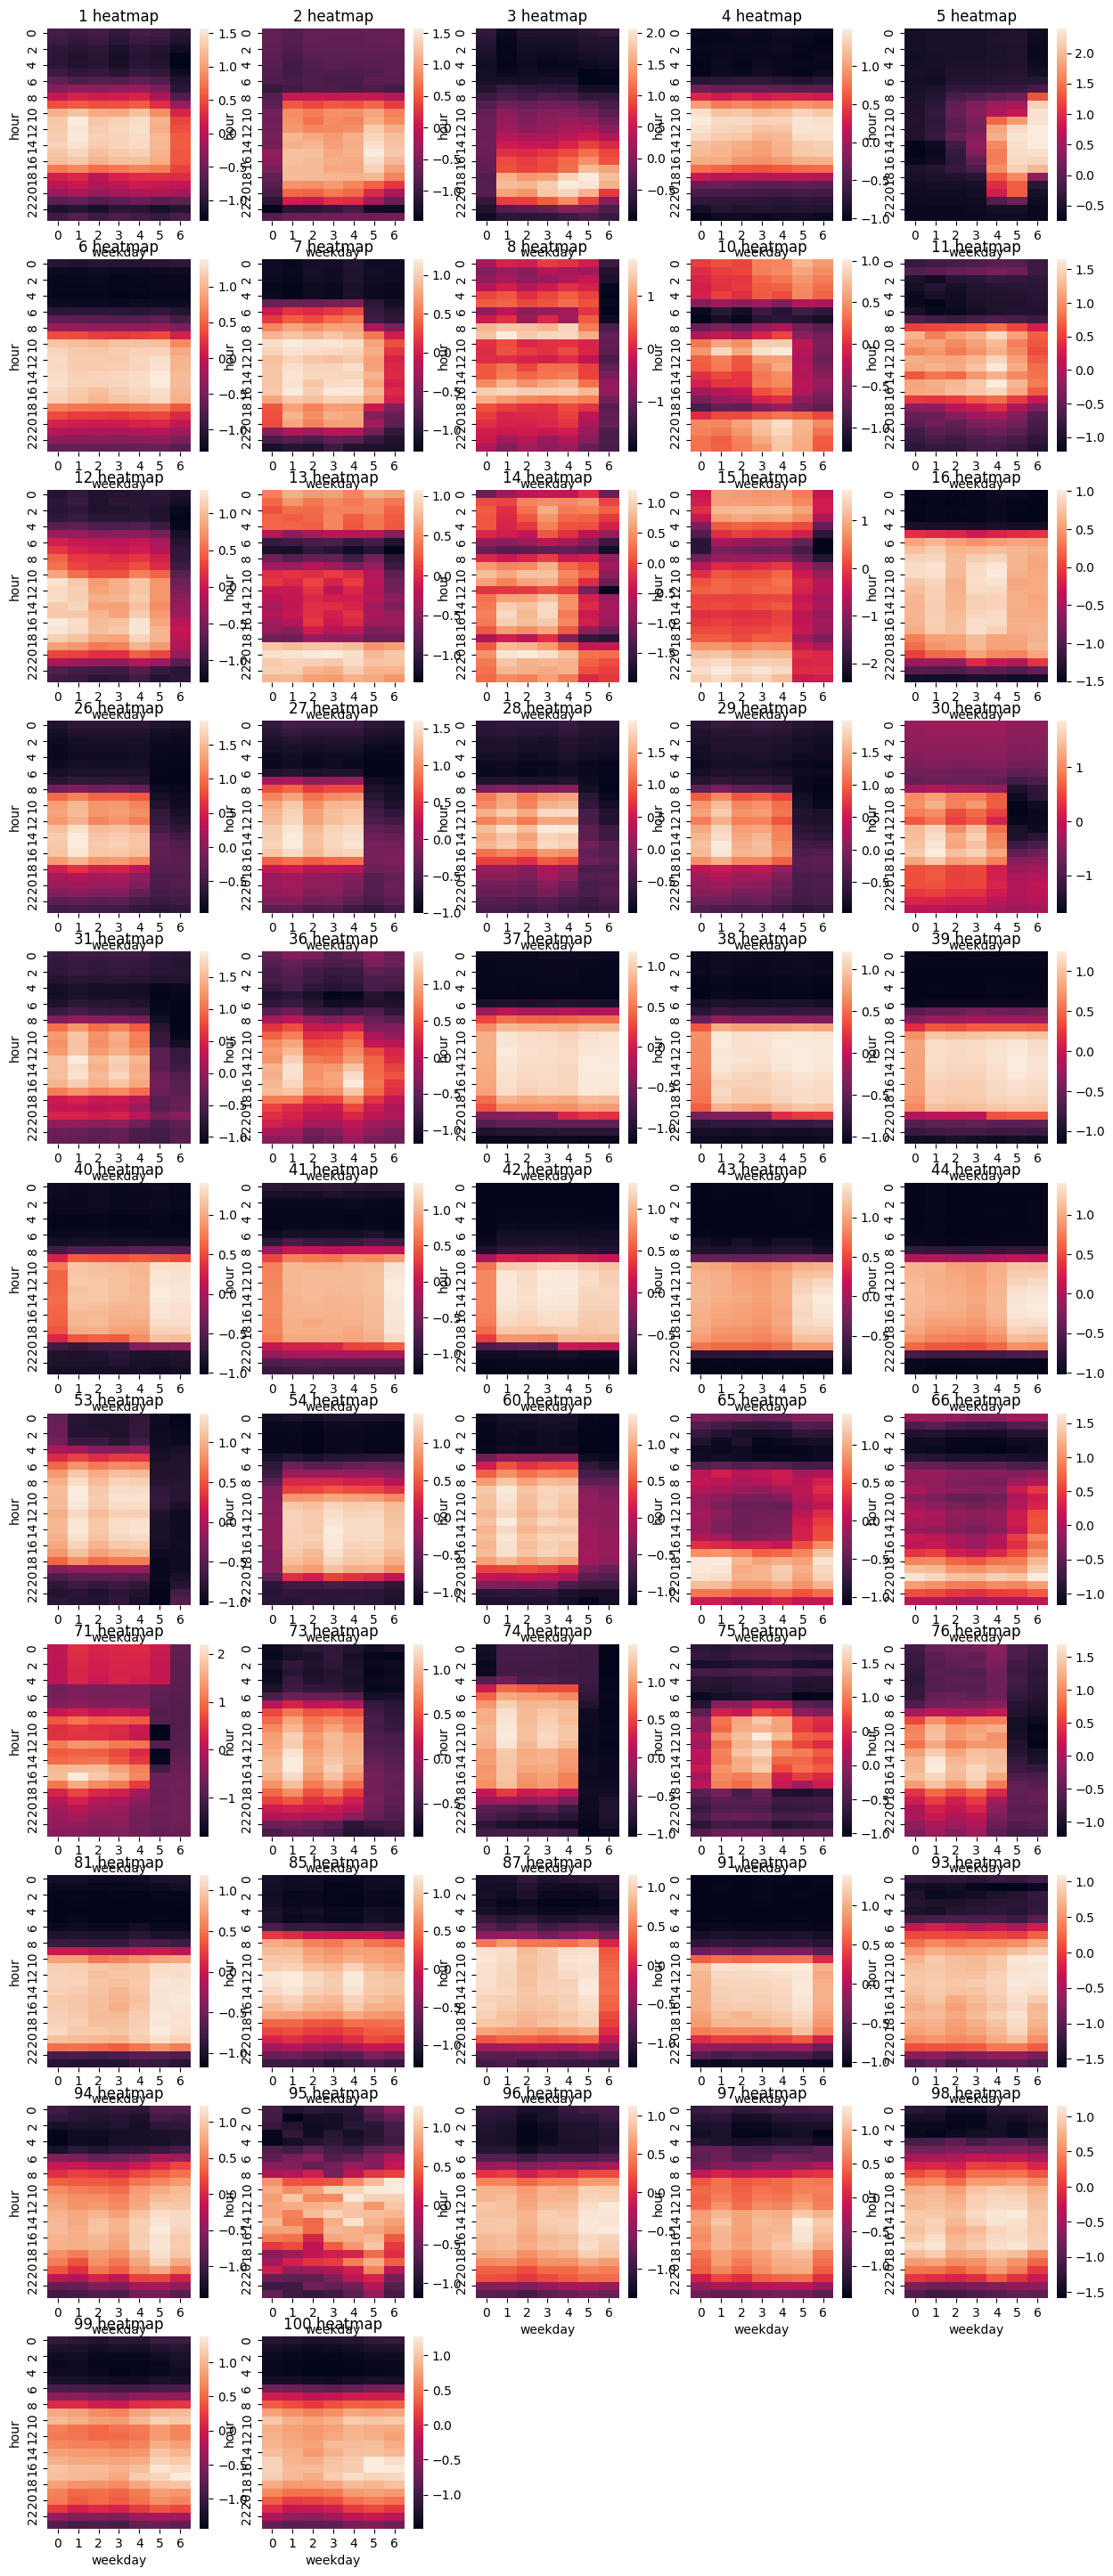

In [162]:
# -1군집 : 남은거 다 들어간 느낌 ..
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(db_m1):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

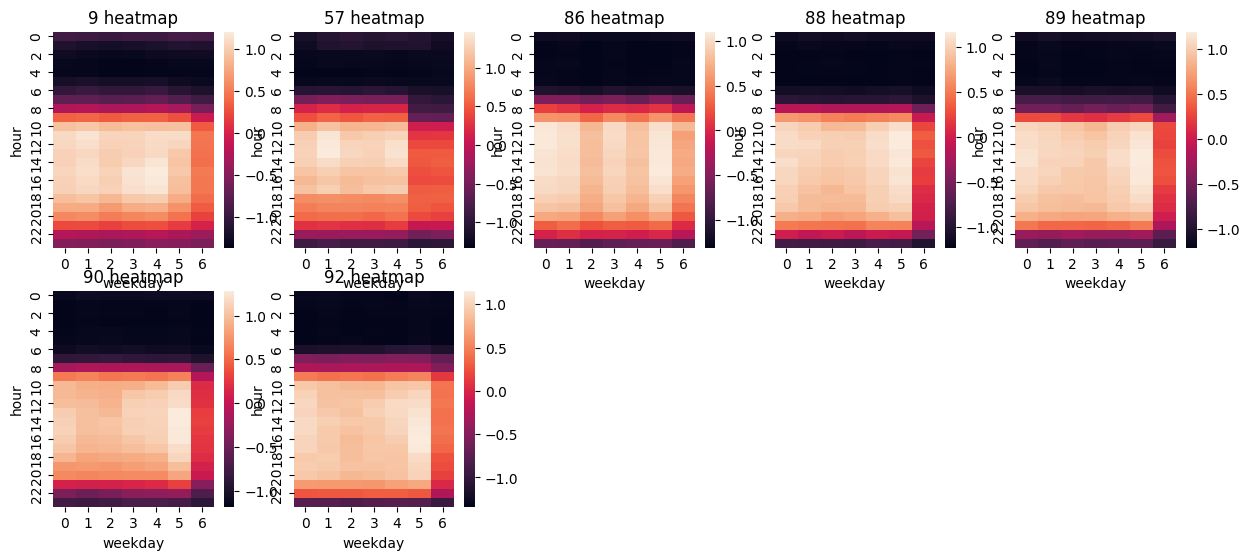

In [158]:
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(db_0):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

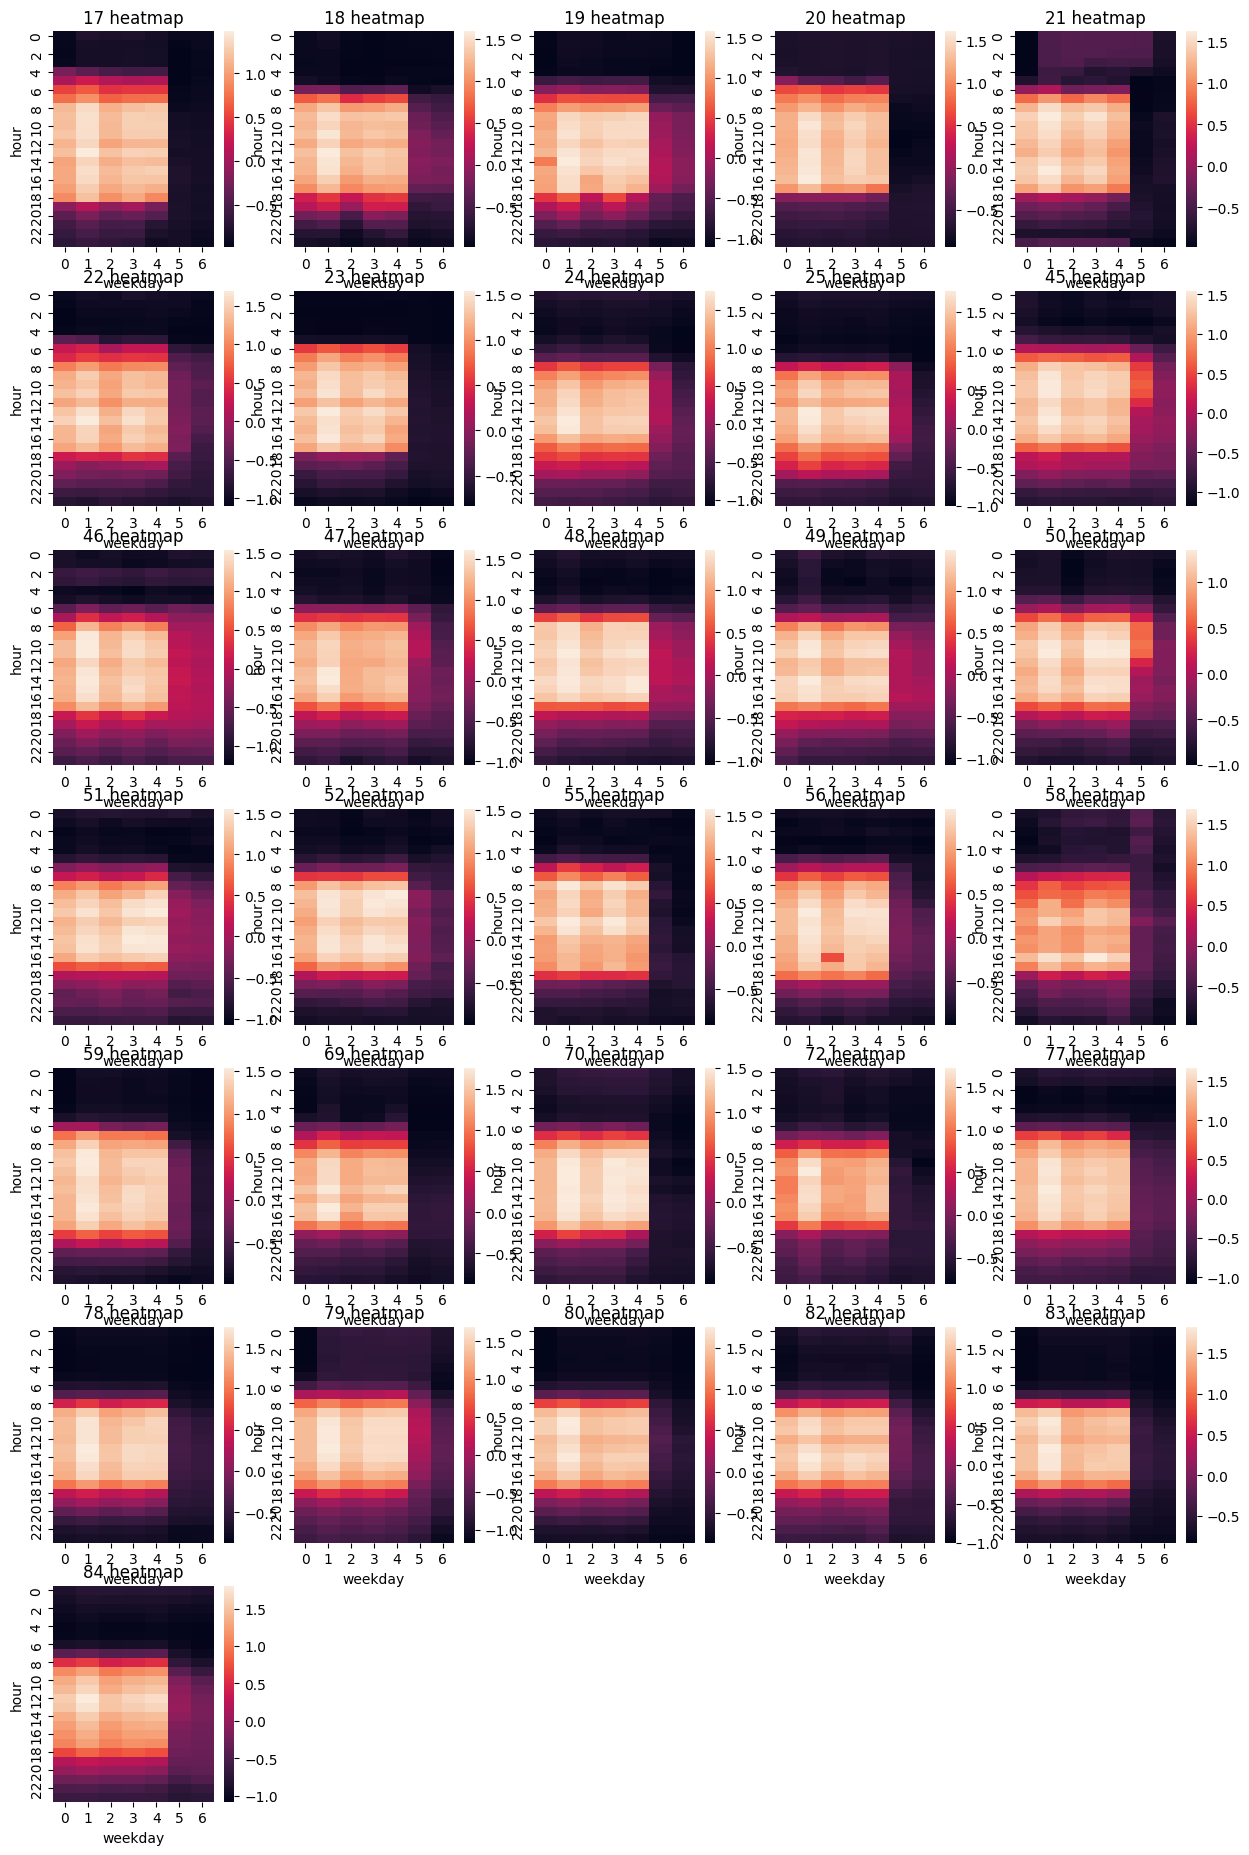

In [159]:
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(db_1):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

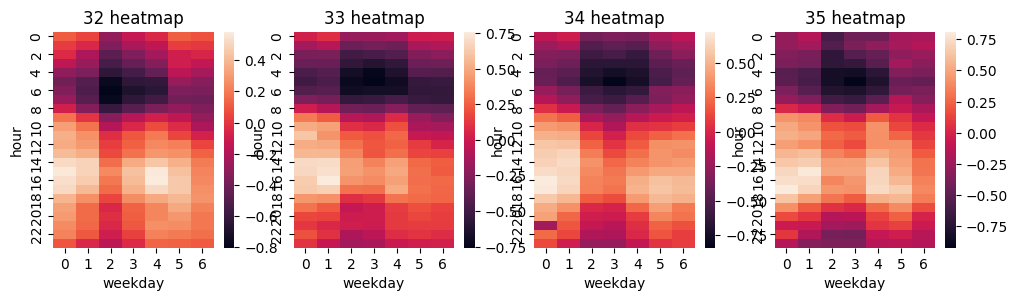

In [163]:
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(db_2):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

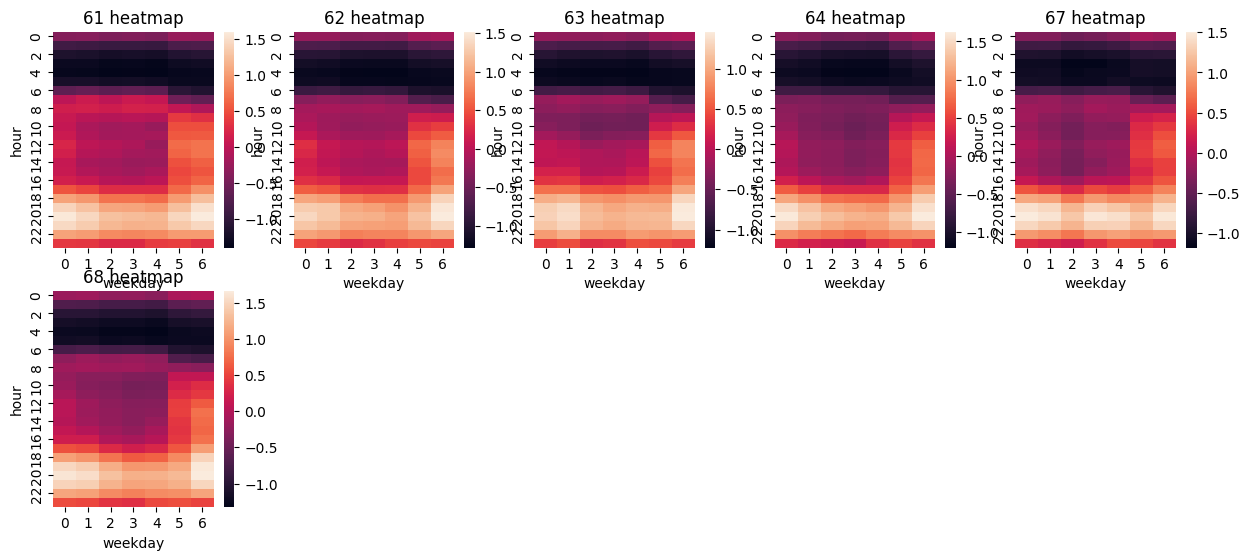

In [164]:
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(db_3):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

In [257]:
#잡다한 -1그룹 다시 dbscan 돌리자
model = DBSCAN(eps=1.5, min_samples=4)
m1_df = cl_df[cl_df['cluster'] == -1]
model.fit(m1_df)
m1_df['cluster'] = model.fit_predict(m1_df.iloc[:,1:])


<ipython-input-257-1092c7bb1fe5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1_df['cluster'] = model.fit_predict(m1_df.iloc[:,1:])


In [258]:
train_m1 = pd.merge(train, m1_df[['building_number','cluster']],how='left',on='building_number')
test_m1 = test.copy()
for i in range(1, 101):
    test_m1.loc[test_m1.building_number == i, 'cluster'] = (
        train_m1.loc[train_m1.building_number == i, 'cluster'].max()
    )


In [259]:
train_m1.cluster.value_counts()

 0.0    55080
-1.0    24480
 1.0    22440
Name: cluster, dtype: int64

In [260]:
cl_m1 = list(train_m1.loc[train_m1.cluster == -1].building_number.unique())
cl_0 = list(train_m1.loc[train_m1.cluster == 0].building_number.unique())
cl_1 = list(train_m1.loc[train_m1.cluster == 1].building_number.unique())

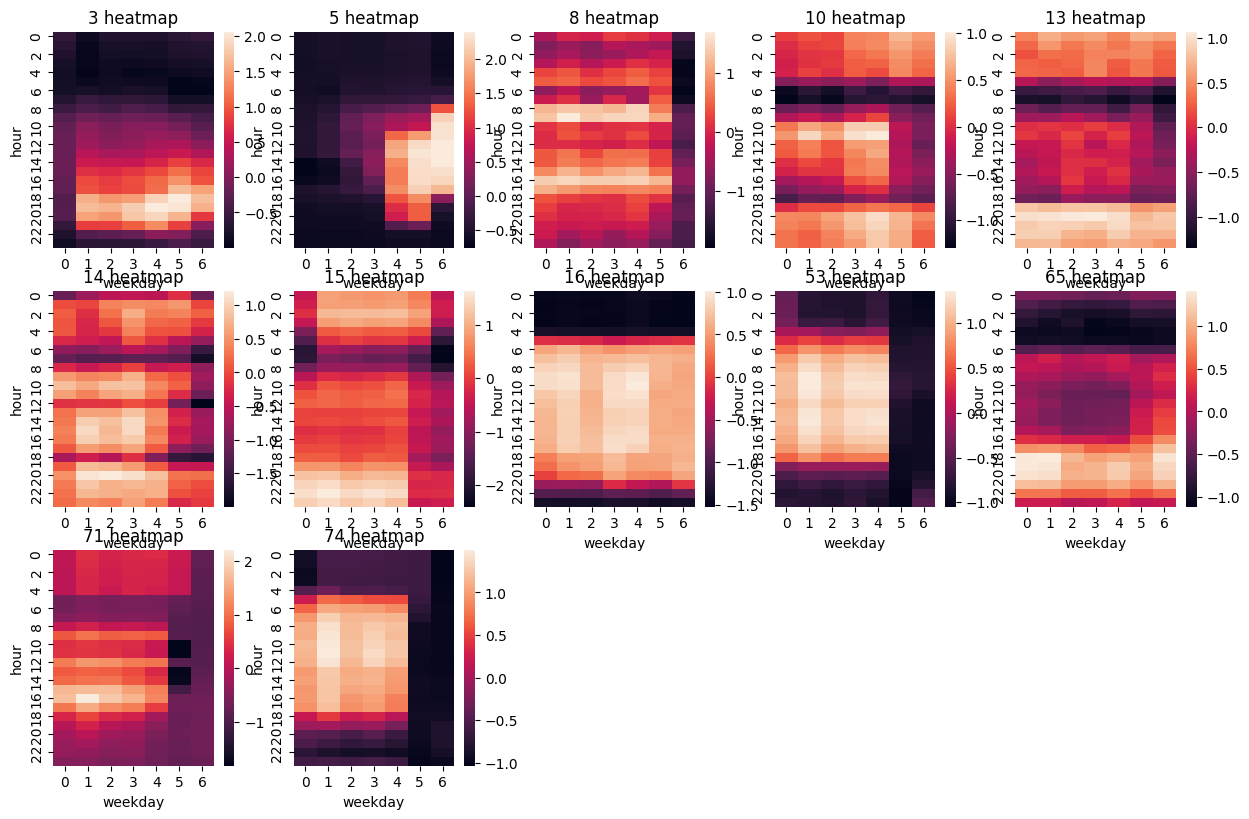

In [261]:
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(cl_m1):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

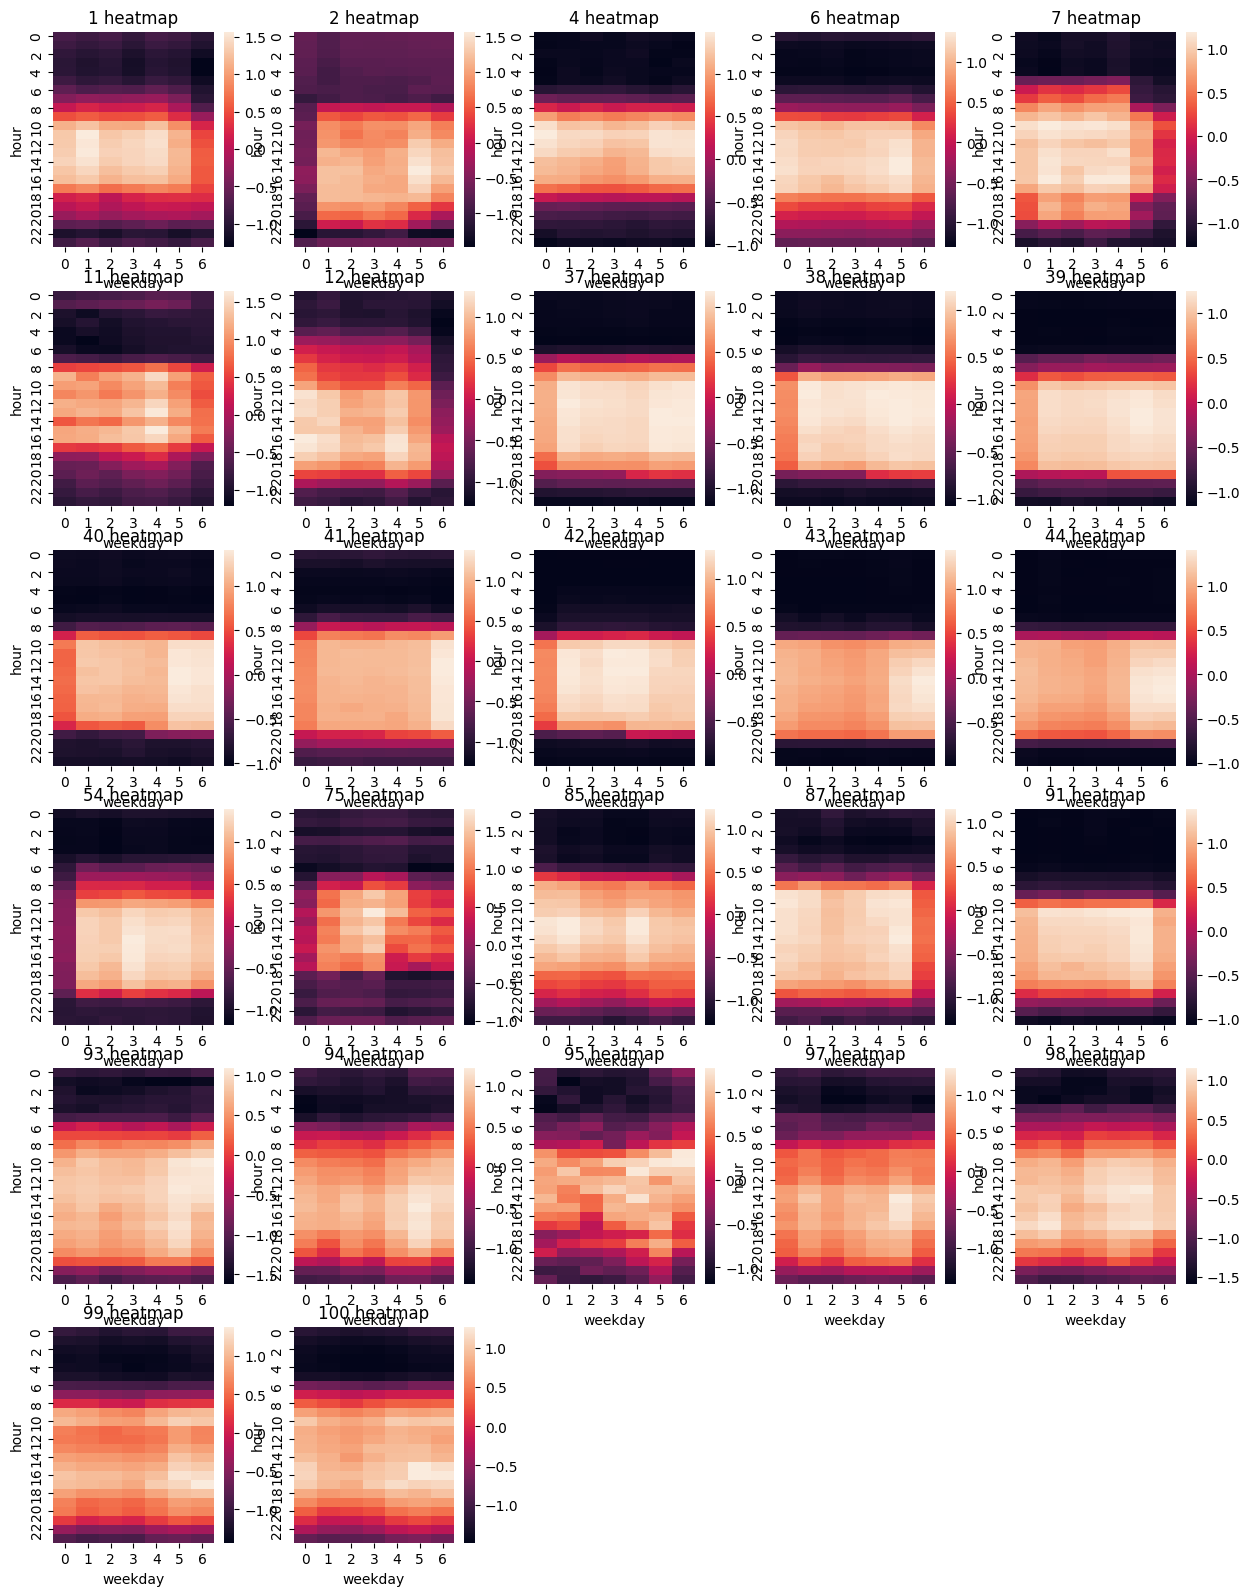

In [262]:
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(cl_0):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

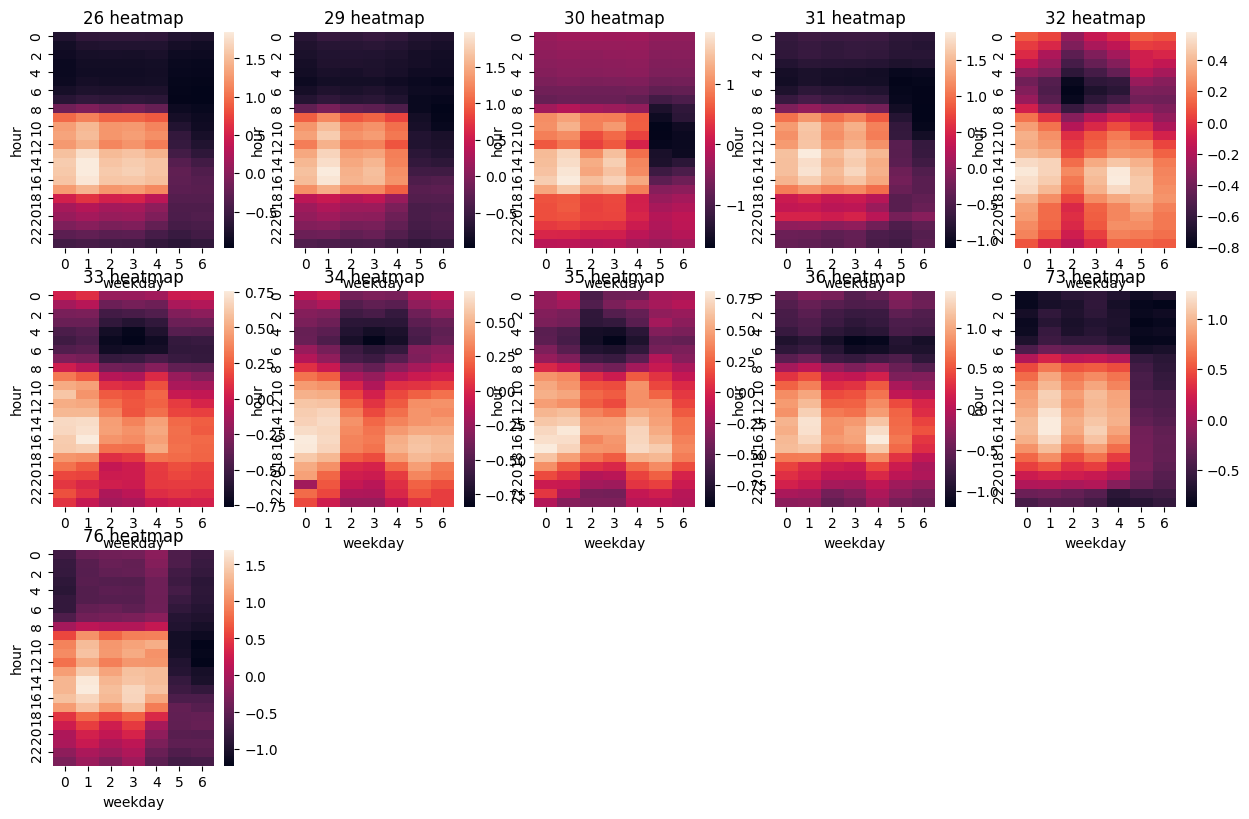

In [263]:
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(cl_1):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

In [264]:
print(len(db_0))
print(len(db_1))
print(len(db_2))
print(len(db_3))
print(len(cl_m1))
print(len(cl_0))
print(len(cl_1))
#건물 2개는 군집에 들어가지 못함


7
31
4
6
12
27
11


## K-means 군집화

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

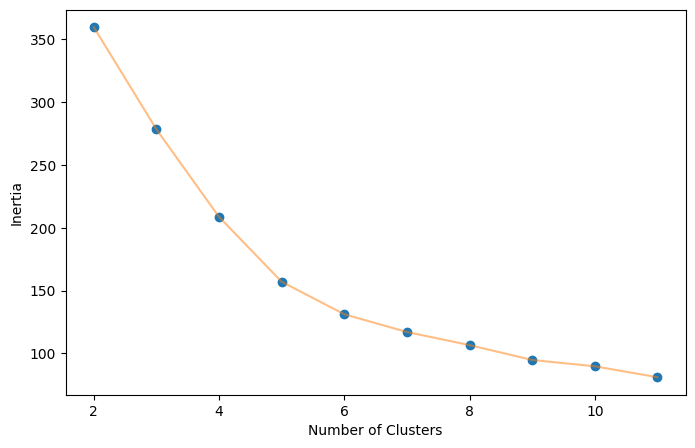

In [266]:
#동준이님 코드
# elbow method를 통해 군집의 개수 결정
from sklearn.cluster import KMeans
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [291]:
kmeans = KMeans(n_clusters=5, random_state = 2)
km_cluster = kmeans.fit_predict(cl_df.iloc[:,1:])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [292]:
cl_df_clust = cl_df.copy()
cl_df_clust['km_cluster'] = km_cluster
cl_df_clust['km_cluster'] = cl_df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

In [293]:
eda_df = train.copy()

In [294]:
eda_df = eda_df.merge(cl_df_clust[['building_number','km_cluster']], on = 'building_number', how = 'left')

In [295]:
kmeans_0 = list(eda_df.loc[eda_df.km_cluster == 0].building_number.unique())
kmeans_1 = list(eda_df.loc[eda_df.km_cluster == 1].building_number.unique())
kmeans_2 = list(eda_df.loc[eda_df.km_cluster == 2].building_number.unique())
kmeans_3 = list(eda_df.loc[eda_df.km_cluster == 3].building_number.unique())

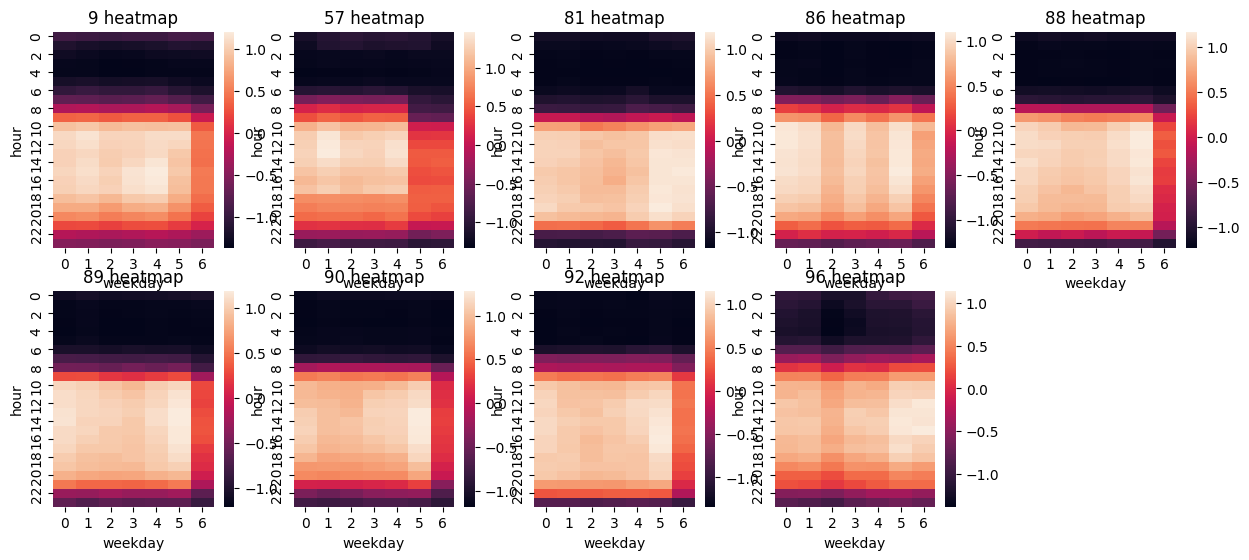

In [296]:
#kmeans 군집 0 시각화
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(kmeans_0):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

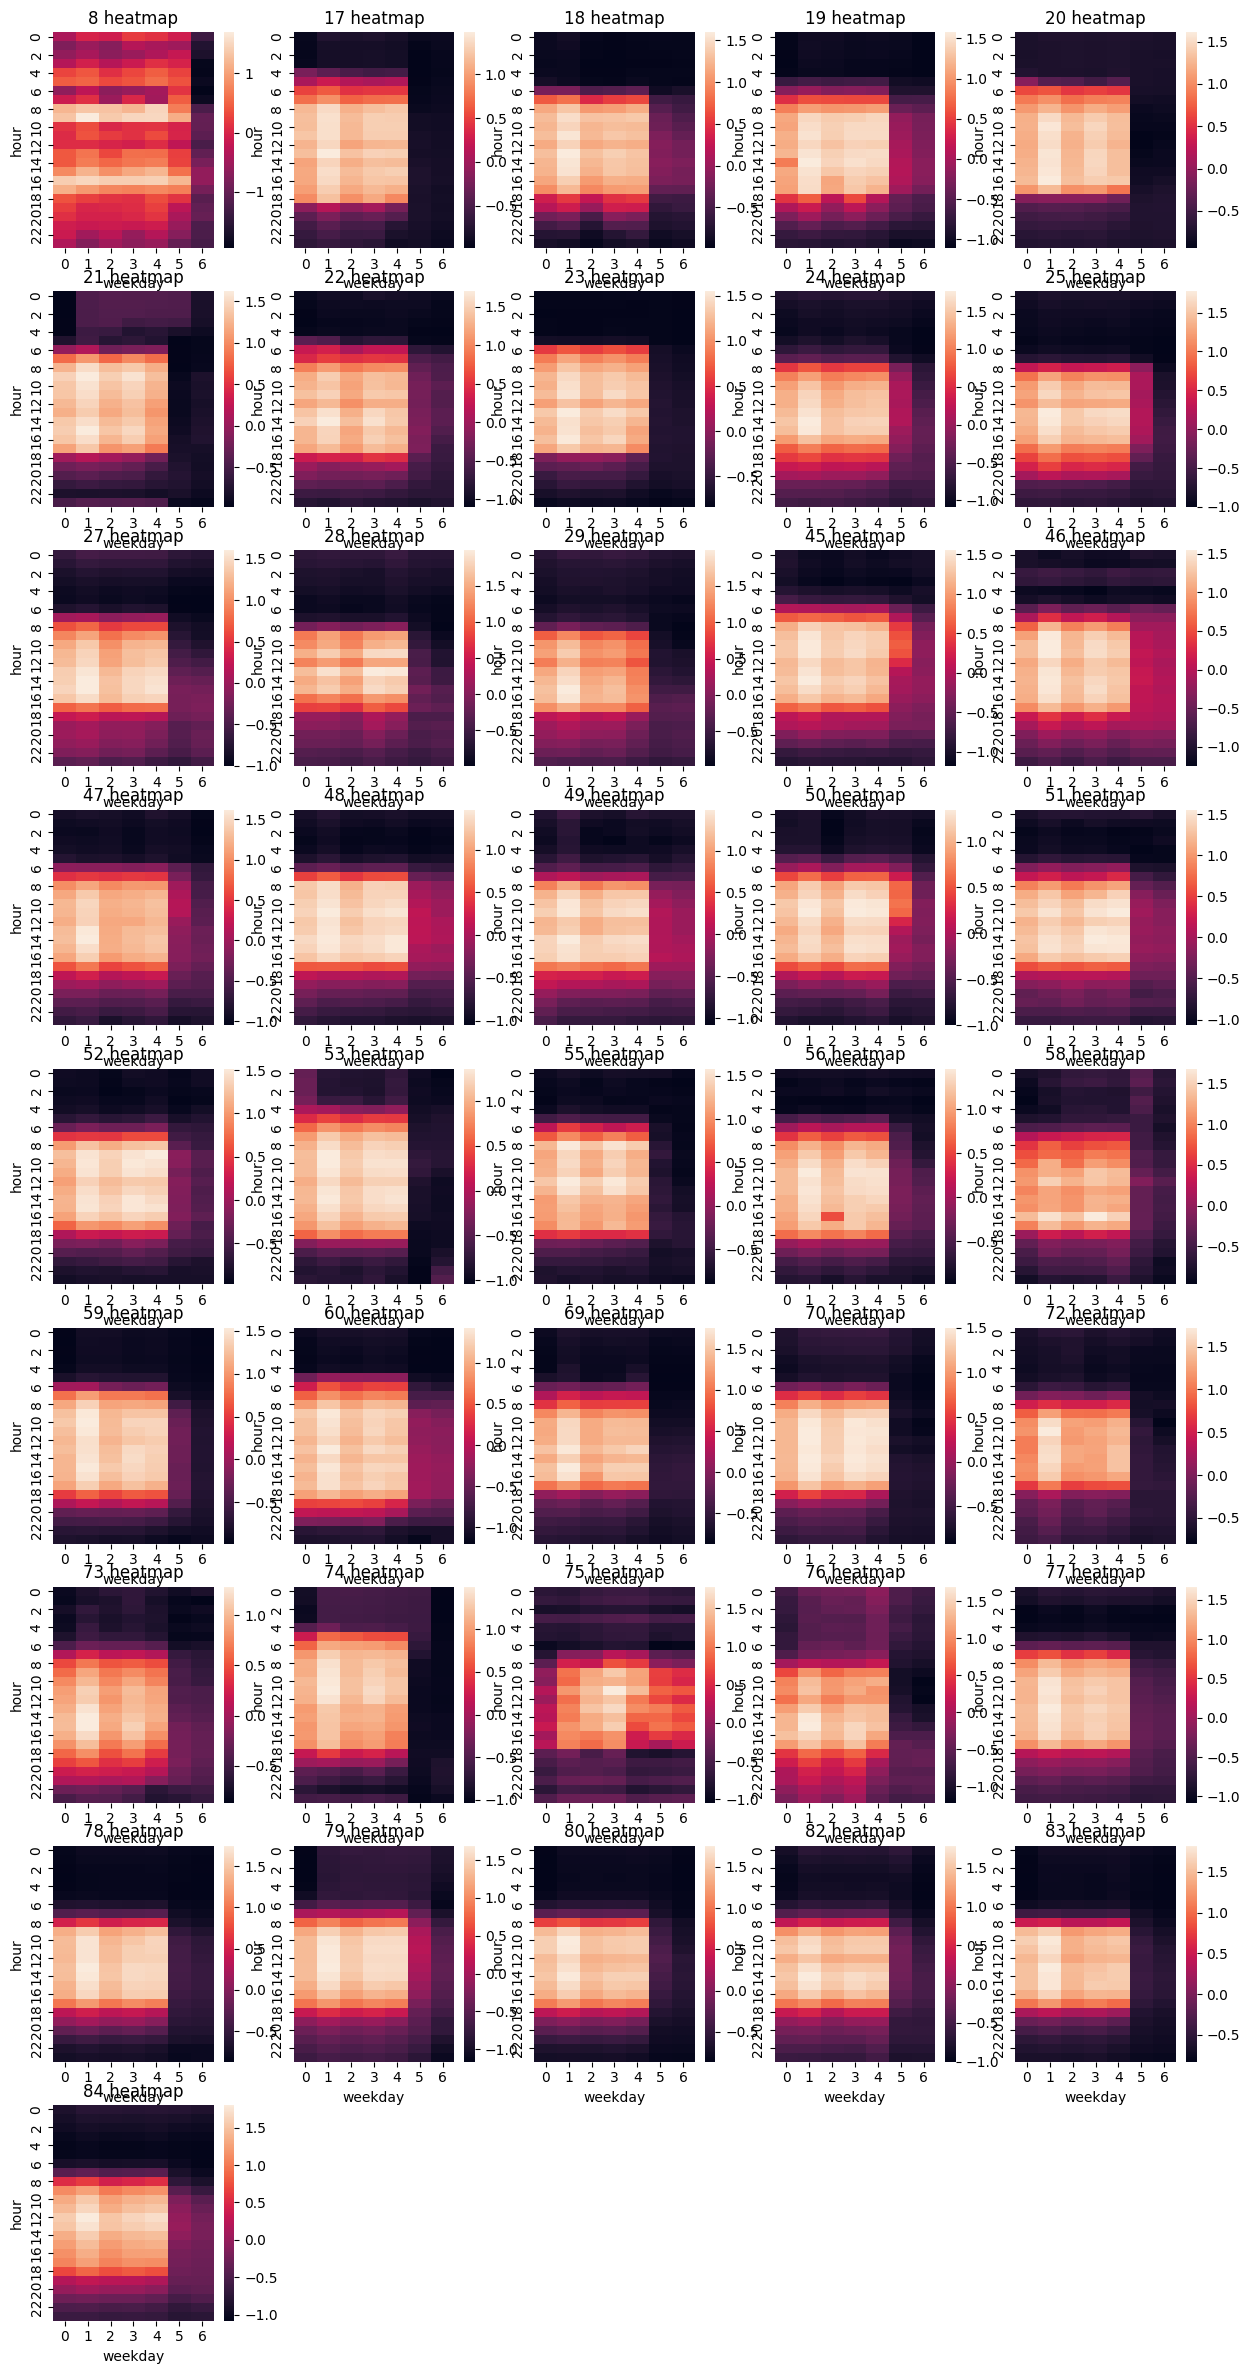

In [297]:
#kmeans 군집 1 시각화
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(kmeans_1):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

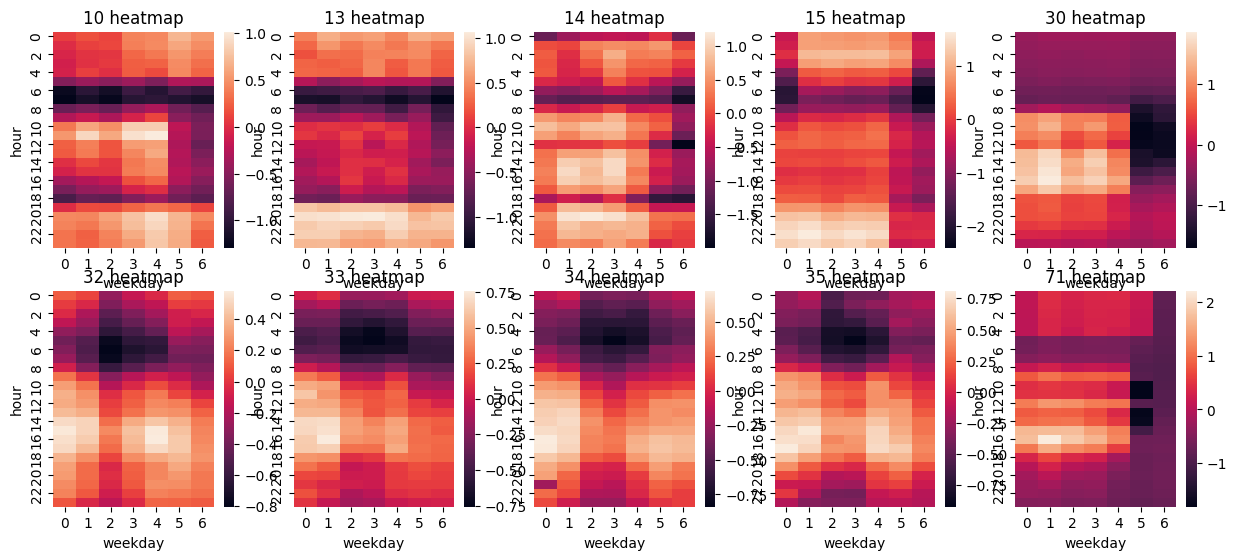

In [298]:
#kmeans 군집 2 시각화
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(kmeans_2):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

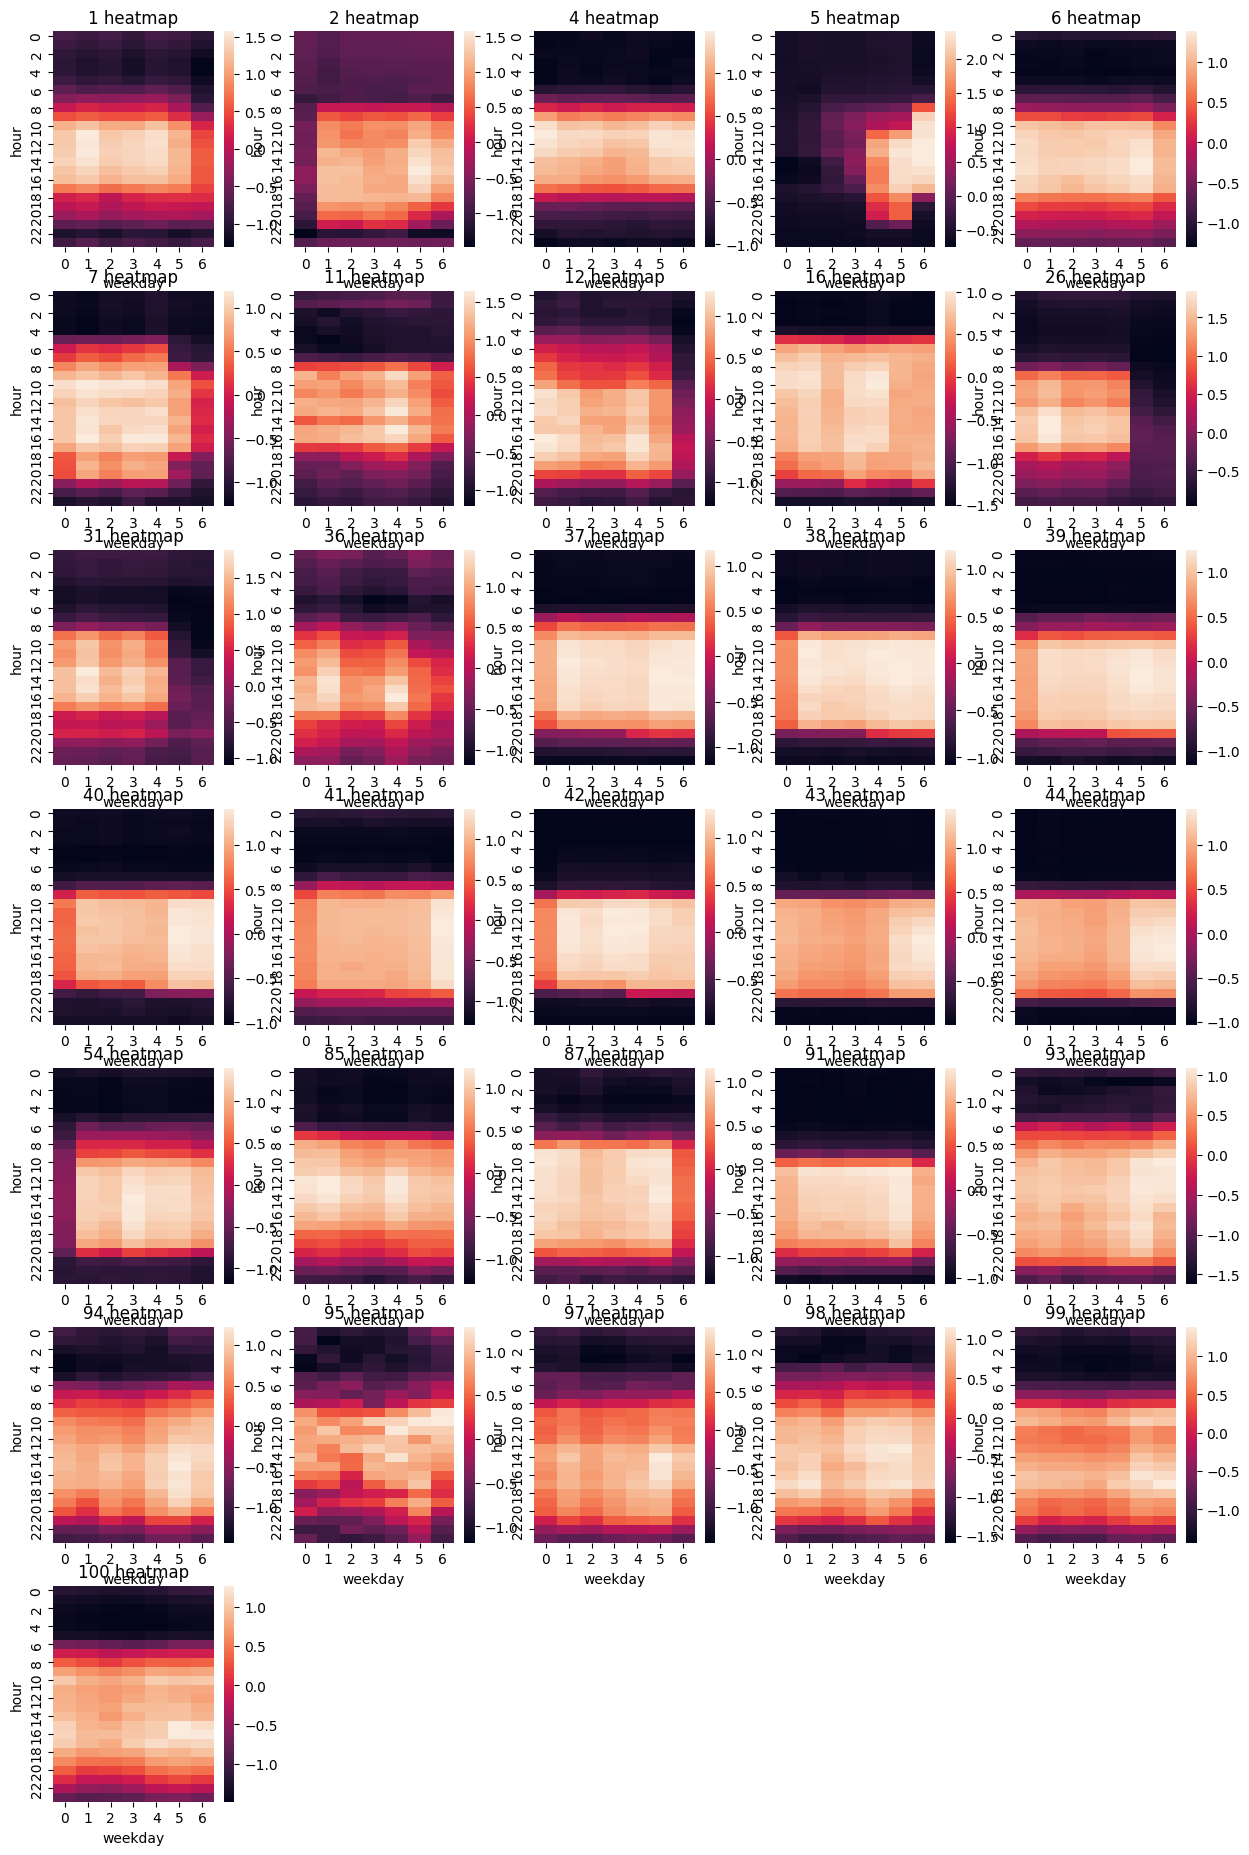

In [299]:
#kmeans 군집 3 시각화
fig = plt.figure(figsize = (15, 60))
for i, n in enumerate(kmeans_3):
  plt.subplot(18,5,i+1)
  plt.title("{} heatmap".format(n))
  sns.heatmap(train.loc[train.building_number == n].groupby(['weekday', 'hour'])['power_consumption'].mean().unstack().T)

건물유형-번호매칭


'건물기타': 1, '공공': 2, '대학교': 3, '데이터센터': 4, '백화점및아울렛': 5, '병원': 6, '상용': 7, '아파트': 8, '연구소': 9, '지식산업센터': 10, '할인마트': 11, '호텔및리조트': 12

In [301]:
#0번 군집 : (주말 상관없이)낮시간대에만 켜짐
# 건물기타 1, 아파트 1, 상용1, 지식산업센터 1, 호텔및리조트 1, 할인마트 5
eda_df[eda_df.km_cluster == 0]['building_type'].value_counts()

11    10200
1      2040
7      2040
10     2040
12     2040
Name: building_type, dtype: int64

In [303]:
#1번 군집 : (주말 쉬고)낮시간대에만 켜짐
# 병원 8, 공공 7, 연구소 7, 지식산업센터 7, 상용 6, 대학교 5, 건물기타 1
eda_df[eda_df.km_cluster == 1]['building_type'].value_counts()

6     16320
2     14280
9     14280
10    14280
7     12240
3     10200
1      2040
Name: building_type, dtype: int64

In [304]:
#2번 군집 : 거의 걍 켜짐
# 건물기타 4, 데이터센터 4, 대학교 1, 연구소 1
eda_df[eda_df.km_cluster == 2]['building_type'].value_counts()

1    8160
4    8160
3    2040
9    2040
Name: building_type, dtype: int64

In [305]:
#3번 군집 : 한마디로는 잘 설명이 안되지만 일단 낮에만 거의 사용한다는점?
# 건물기타 8, 백화점및아울렛 8, 호텔및리조트 7, 할인마트 3, 대학교 2, 공공 1, 데이터센터 1, 상용 1
eda_df[eda_df.km_cluster == 3]['building_type'].value_counts()

1     16320
5     16320
12    14280
11     6120
3      4080
2      2040
4      2040
7      2040
Name: building_type, dtype: int64